In [1]:
import pandas as pd
import numpy as np
import os as os
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.util import ngrams
import aux.acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re
from datetime import date
from sqlalchemy import create_engine
from unidecode import unidecode
from xhtml2pdf import pisa
import markdown
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Função de Amostragem

In [2]:
def sampleSize(
    population_size,
    margin_error,
    confidence_level,
    sigma=1/2
):
    """
    Calculate the minimal sample size to use to achieve a certain
    margin of error and confidence level for a sample estimate
    of the population mean.
    Inputs
    -------
    population_size: integer
        Total size of the population that the sample is to be drawn from.
    margin_error: number
        Maximum expected difference between the true population parameter,
        such as the mean, and the sample estimate.
    confidence_level: number in the interval (0, 1)
        If we were to draw a large number of equal-size samples
        from the population, the true population parameter
        should lie within this percentage
        of the intervals (sample_parameter - e, sample_parameter + e)
        where e is the margin_error.
    sigma: number
        The standard deviation of the population.  For the case
        of estimating a parameter in the interval [0, 1], sigma=1/2
        should be sufficient.
    """
    alpha = 1 - (confidence_level)
    # dictionary of confidence levels and corresponding z-scores
    # computed via norm.ppf(1 - (alpha/2)), where norm is
    # a normal distribution object in scipy.stats.
    # Here, ppf is the percentile point function.
    zdict = {
        .90: 1.645,
        .91: 1.695,
        .99: 2.576,
        .97: 2.17,
        .94: 1.881,
        .93: 1.812,
        .95: 1.96,
        .98: 2.326,
        .96: 2.054,
        .92: 1.751
    }
    if confidence_level in zdict:
        z = zdict[confidence_level]
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - (alpha/2))
    N = population_size
    M = margin_error
    numerator = z**2 * sigma**2 * (N / (N-1))
    denom = M**2 + ((z**2 * sigma**2)/(N-1))
    return numerator/denom

In [3]:
query_count = """

select 
count(distinct msg.id_issue) as nr_chats
from cx_curated_zone.helpshift_issues_messages msg
where ds_entidade = 'cliente'
and dt_envio_mensagem >= date_add('day', -360,now())
       and lower(ds_message) <> 'screenshot sent'
        and lower(ds_message) <> 'ok'
        and lower(ds_message) <> 'outros assuntos'
        and lower(ds_message) <> 'não, ainda tenho dúvidas'
        and lower(ds_message) <> 'obrigado'
        and lower(ds_message) <> 'obrigada'
        and lower(ds_message) <> 'quero falar de outra coisa'
        and lower(ds_message) <> 'quero falar com atendimento'
        and lower(ds_message) <> 'falar atendimento'
        and lower(ds_message) <> 'quero falar com atendente'
        and lower(ds_message) <> 'nenhuma das opções'
        and lower(ds_message) <> 'certo'
        and lower(ds_message) <> 'responde'
        and lower(ds_message) <> 'falar com atendente'
        and lower(ds_message) <> 'ainda preciso de ajuda'
        and lower(ds_message) <> 'sim, ainda preciso de ajuda'
        and lower(ds_message) <> 'voltar pras opções de antes'
        and lower(ds_message) <> 'me mostra as opções de antes'
        and lower(ds_message) <> 'quero negociar pelo chat'
        and lower(ds_message) <> 'quero negociar a fatura'
        and lower(ds_message) <> 'é outra coisa'
        and lower(ds_message) <> 'nenhuma dessas'
        and lower(ds_message) <> 'sim'
        and lower(ds_message) <> 'não'
        and lower(ds_message) <> 'nao'
        and lower(ds_message) <> 'oi'
        and lower(ds_message) <> '?'
        and lower(ds_message) <> '??'
        and lower(ds_message) <> 'bom dia'
        and lower(ds_message) <> 'boa tarde'
        and lower(ds_message) <> 'boa noite'

"""

count = ac.df_athena('flavia-costa', query_count)

In [4]:
print(count)

   nr_chats
0   6361414


In [5]:
confidence_level = 0.99
margin_error = 0.005

In [6]:
nr_amostra = round(sampleSize(population_size = count.iloc[0,0], margin_error = margin_error, confidence_level= confidence_level), 0).astype('int')

In [7]:
nr_amostra

65673

## QUERY

In [8]:
query = """

select 
    msg.id_issue
    , msg.dt_envio_mensagem
    , nm_entidade
    , msg.ds_message
    , novas_tags.hierarquia_4
    , novas_tags.fila_de_atendimento
    , case 

when (novas_tags.hierarquia_4 like '%%Alteração de endereço%%'
  or novas_tags.hierarquia_4 like '%%Atraso de entrega%%'
  or novas_tags.hierarquia_4 like '%%Custódia%%'
  or novas_tags.hierarquia_4 like '%%Devolução%%'
  or novas_tags.hierarquia_4 like '%%Problema no recebimento do cartão%%'
  or novas_tags.hierarquia_4 like '%%Segunda via cartão%%'
  or novas_tags.hierarquia_4 like '%%Rastreio de cartão%%'
  or novas_tags.hierarquia_4 like '%%Primeiro Desbloqueio de cartão%%') then 'Logistica'
when trim(novas_tags.hierarquia_3) in ('Aquisição', 'Aprovação') then 'Aquisição'
when trim(novas_tags.hierarquia_3) in ('Diversificação', 'Marketplace','Product Marketing', 'Crédito Pessoal', 'FGTS') then 'Novos produtos ou campanhas'
when trim(novas_tags.hierarquia_3) in ('Cash In - Pix', 'Cash Out - Pix') then 'Pix'
when trim(novas_tags.hierarquia_3) in ('Conta', 'Conta Will','Account','Cash In','Cash Out','Cash In - Growth','Cash Out - Monetization') then 'Conta'
when trim(novas_tags.hierarquia_3) in ('Atendimento', 'Bot') then 'Atendimento'
when lower(novas_tags.fila_de_atendimento) = 'pagamento' then 'Pagamento'
when lower(novas_tags.fila_de_atendimento) = 'cobrança' then 'Acordos'
    else novas_tags.hierarquia_3 
    end as hierarquia_analise
from 
    cx_curated_zone.helpshift_issues_messages msg
left join cx_curated_zone.helpshift_tag_niveis AS helpshift_tag 
    on msg.id_issue = helpshift_tag.id_issue
left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags 
    on trim(lower(n3)) = trim(lower(nm_tag_n3))
where 
    ds_entidade = 'cliente'
    and dt_envio_mensagem >= date_trunc('month', date_add('day', -360,now()))
       and lower(ds_message) <> 'screenshot sent'
        and lower(ds_message) <> 'ok'
        and lower(ds_message) <> 'outros assuntos'
        and lower(ds_message) <> 'não, ainda tenho dúvidas'
        and lower(ds_message) <> 'obrigado'
        and lower(ds_message) <> 'obrigada'
        and lower(ds_message) <> 'quero falar de outra coisa'
        and lower(ds_message) <> 'quero falar com atendimento'
        and lower(ds_message) <> 'falar atendimento'
        and lower(ds_message) <> 'quero falar com atendente'
        and lower(ds_message) <> 'nenhuma das opções'
        and lower(ds_message) <> 'certo'
        and lower(ds_message) <> 'responde'
        and lower(ds_message) <> 'falar com atendente'
        and lower(ds_message) <> 'ainda preciso de ajuda'
        and lower(ds_message) <> 'sim, ainda preciso de ajuda'
        and lower(ds_message) <> 'voltar pras opções de antes'
        and lower(ds_message) <> 'me mostra as opções de antes'
        and lower(ds_message) <> 'quero negociar pelo chat'
        and lower(ds_message) <> 'quero negociar a fatura'
        and lower(ds_message) <> 'é outra coisa'
        and lower(ds_message) <> 'nenhuma dessas'
        and lower(ds_message) <> 'sim'
        and lower(ds_message) <> 'não'
        and lower(ds_message) <> 'nao'
        and lower(ds_message) <> 'oi'
        and lower(ds_message) <> '?'
        and lower(ds_message) <> '??'
        and lower(ds_message) <> 'bom dia'
        and lower(ds_message) <> 'boa tarde'
        and lower(ds_message) <> 'boa noite'
order by rand() desc

"""

query = query + "limit " + str(nr_amostra)


df = ac.df_athena_q('flavia-costa', query)

In [9]:
df['hierarquia_analise'].value_counts()

Pagamento                      17241
Compra                         14976
Logistica                       8254
Aquisição                       4807
Limite de crédito               4755
Pix                             2860
Acordos                         2438
Fraude                          1678
Assunto não identificado        1122
Banking Transfers               1029
Atendimento                      746
Tecnologia                       743
Novos produtos ou campanhas      430
Banking Account                  253
Acquisition                      218
Empréstimo                       112
Conta                             90
Investments                       75
Riscos 2 nivel                    71
Pix Service                       38
Ativação                          26
Name: hierarquia_analise, dtype: int64

In [10]:
8439 / nr_amostra

0.12850029692567722

In [11]:
df['dt_envio_mensagem'].astype("string").str[0:7].value_counts()

2023-05    6389
2023-07    5911
2023-04    5732
2023-03    5648
2022-09    5456
2023-06    5454
2022-08    5423
2022-12    5217
2022-11    5194
2022-10    5188
2023-01    5078
2023-02    4465
2023-08     518
Name: dt_envio_mensagem, dtype: Int64

## Funções de tratamento

In [12]:
def replace_unuseful_messages(text):
    '''
    Replace automatic and irrelevant (for the project purpose) messages with empty string
    '''
    unuseful_messages = [
        'Outros assuntos',
        'Quero falar de outra coisa',
        'Quero resolver uma coisa',
        'Falar com atendente',
        '&Eacute; outra coisa',
        '&Eacute; outro assunto',
        'Voltar pro come&ccedil;o',
        '&Eacute; outro motivo',
        'Quero falar com atendente',
        'Me mostra as op&ccedil;&otilde;es de antes',
        'Quero falar de outro assunto',
        '&Eacute; outro assunto',
        '&Eacute; outra coisa ',
        'N&atilde;o, ainda tenho d&uacute;vidas',
        'Nenhuma das op&ccedil;&otilde;es',
        'Falar de outra coisa',
        'Quero voltar pro come&ccedil;o',
        'Voltar pro come&ccedil;o',
        'Falar com atendente',
        'Pode sim Por favor',
        'Não, ainda tenho dúvidas',
        'Certo',
        'Obrigado',
        'Responde'
    ]

    if text.strip() in unuseful_messages:
        return ''

    return text
def remove_emoji(text):
    '''
    Replace emojis with empty string
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', str(text))

def clean_text(x):
    x = x.strip()
    x = x.lower()
    x = unidecode(x)
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x

def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text

In [13]:
stopwords= ['da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce', 
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um','como', 'meu', 'com', 'outro','outra','das','dos','foi', 'fiz','tem','mas',
            'este', 'esse','ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

## Tratando texto da mensagem
df['ds_message_tratada'] = df['ds_message'].apply(replace_unuseful_messages)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(remove_emoji)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(retira_saudacoes)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df_clean = df.query('ds_message_tratada != " "').query('ds_message_tratada != "  "').query('ds_message_tratada != ""').query('ds_message_tratada != "   "')

In [14]:
df_agg_week = arabica_freq(
                text = df_clean['ds_message_tratada'],
                time = df_clean['dt_envio_mensagem'],
                time_freq = 'M',            
                max_words = 5,              
                stopwords = ['portuguese'], 
                skip = [stopwords],         
                numbers = True,             
                punct = True,               
                lower_case = True)

df_agg_week['termo1'] = df_agg_week['trigram'].str.split(":").str[0]
df_agg_week['termo2'] = df_agg_week['trigram'].str.split(":").str[1]
df_agg_week['termo3'] = df_agg_week['trigram'].str.split(":").str[2]
df_agg_week['termo4'] = df_agg_week['trigram'].str.split(":").str[3]
df_agg_week['termo5'] = df_agg_week['trigram'].str.split(":").str[4]
df_agg_week['freq_termo5'] = df_agg_week['trigram'].str.split(":").str[5]
regex = r"(\d+),"
df_agg_week['freq_termo1']  = df_agg_week['termo2'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
df_agg_week['termo2']  = df_agg_week['termo2'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]
df_agg_week['freq_termo2']  = df_agg_week['termo3'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
df_agg_week['termo3']  = df_agg_week['termo3'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]
df_agg_week['freq_termo3']  = df_agg_week['termo4'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
df_agg_week['termo4']  = df_agg_week['termo4'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]
df_agg_week['freq_termo4']  = df_agg_week['termo5'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
df_agg_week['termo5']  = df_agg_week['termo5'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]
df_agg_week_m = df_agg_week.melt(id_vars=['period'], value_vars=['termo1','termo2','termo3','termo4','termo5']
, var_name='ranking', value_name='descricao').join(
    df_agg_week.melt(id_vars=['period'], value_vars=['freq_termo1', 'freq_termo2', 'freq_termo3', 'freq_termo4', 'freq_termo5']
, var_name='freq', value_name='frequencia')[['frequencia']])
df_agg_week_m['period'] = df_agg_week_m['period'].astype('string')





In [15]:
df_agg_week_m = df_agg_week_m[~df_agg_week_m['descricao'].isna()]

In [16]:
df_agg_week_m

,period,ranking,descricao,frequencia
0,2022-08,termo1,"reconheco,todas,compras",33
1,2022-09,termo1,"quanto,tempo,nome",24
2,2022-10,termo1,"reconheco,todas,compras",29
3,2022-11,termo1,"quero,falar,atendimento",37
4,2022-12,termo1,"pix,nao,caiu",26
...,...,...,...,...
60,2023-04,termo5,"compra,nao,autorizada",20
61,2023-05,termo5,"quero,cancelar,compra",21
62,2023-06,termo5,"reconheco,todas,compras",19
63,2023-07,termo5,"reconheco,todas,compras",21


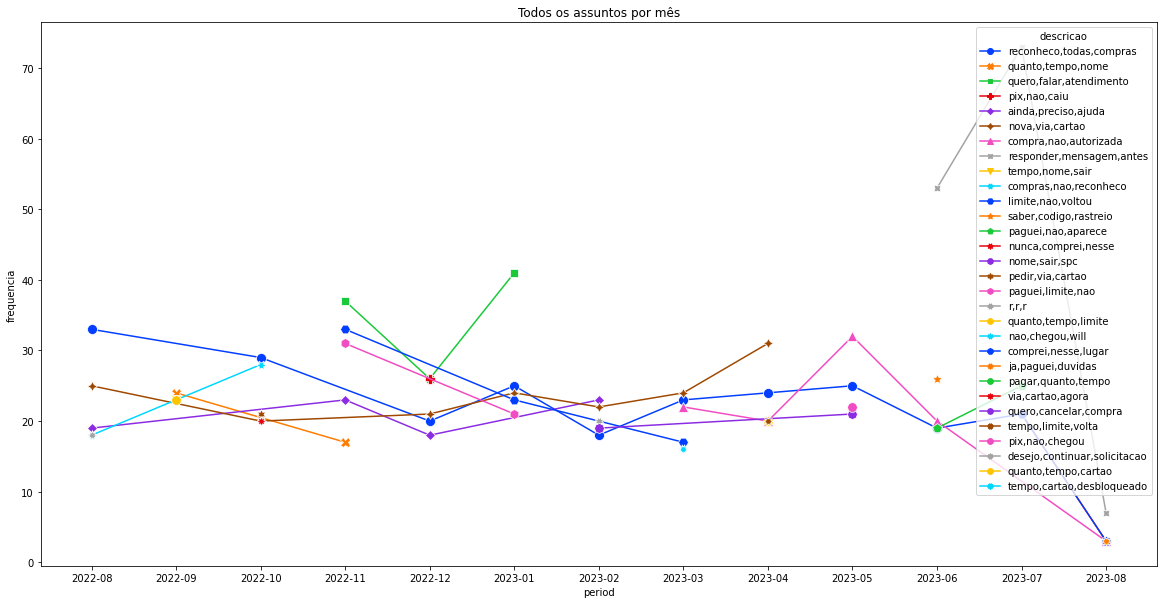

In [17]:
df_agg_week_m['frequencia'] = df_agg_week_m['frequencia'].astype('int')
plt.figure(figsize = (20,10))
sns.lineplot(data=df_agg_week_m, x='period', y='frequencia', hue='descricao', style='descricao', 
             palette="bright", 
             markers=True, dashes=False, markersize=10).set(title="Todos os assuntos por mês")
plt.show()

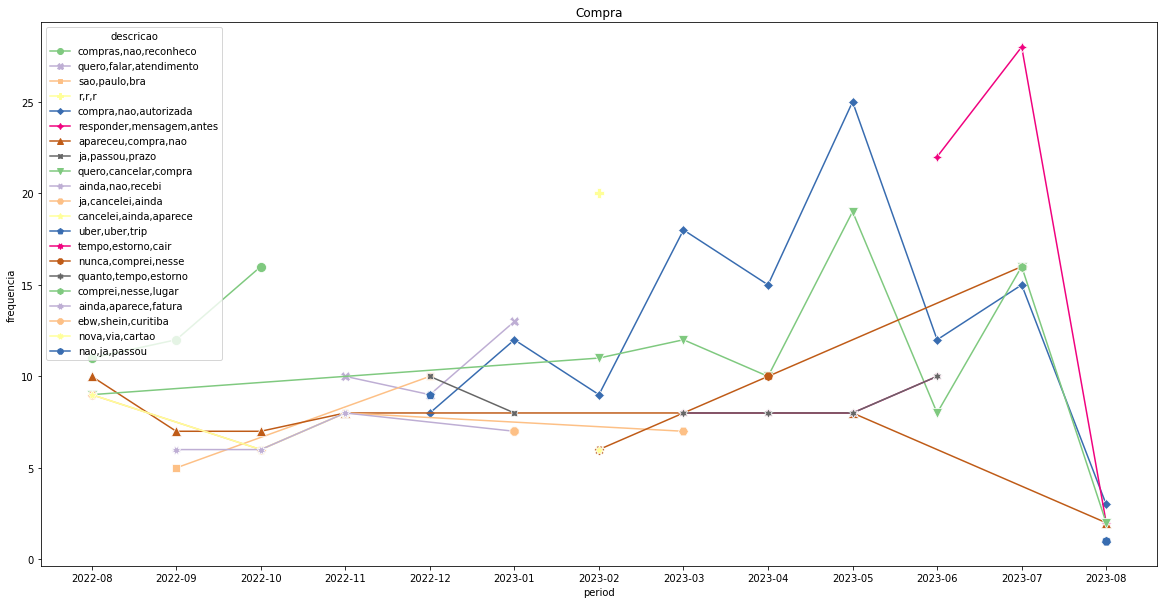

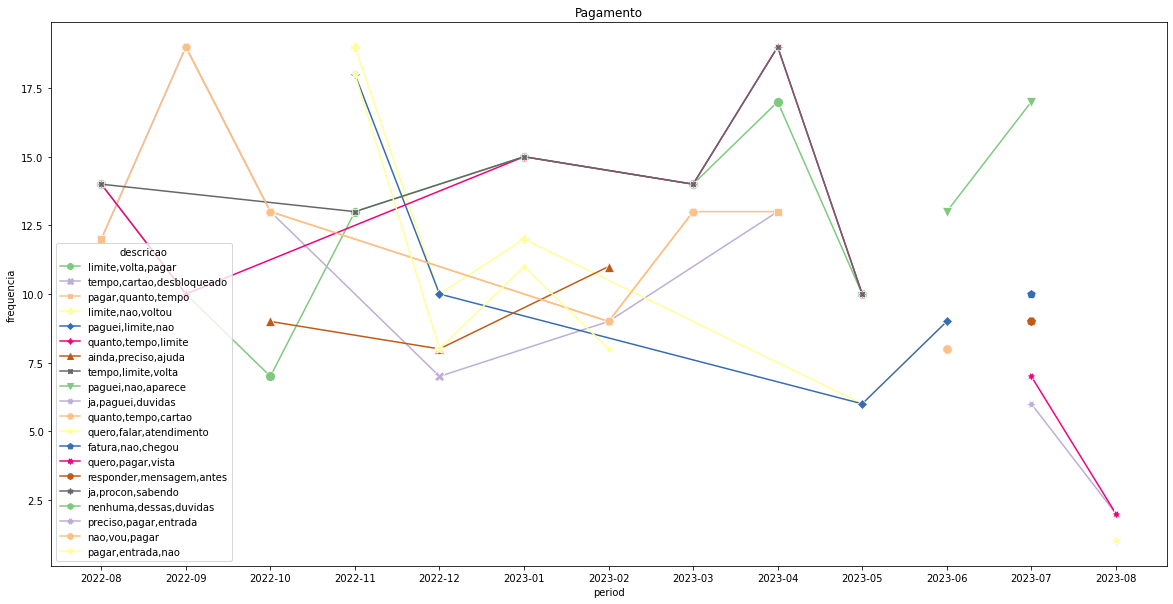

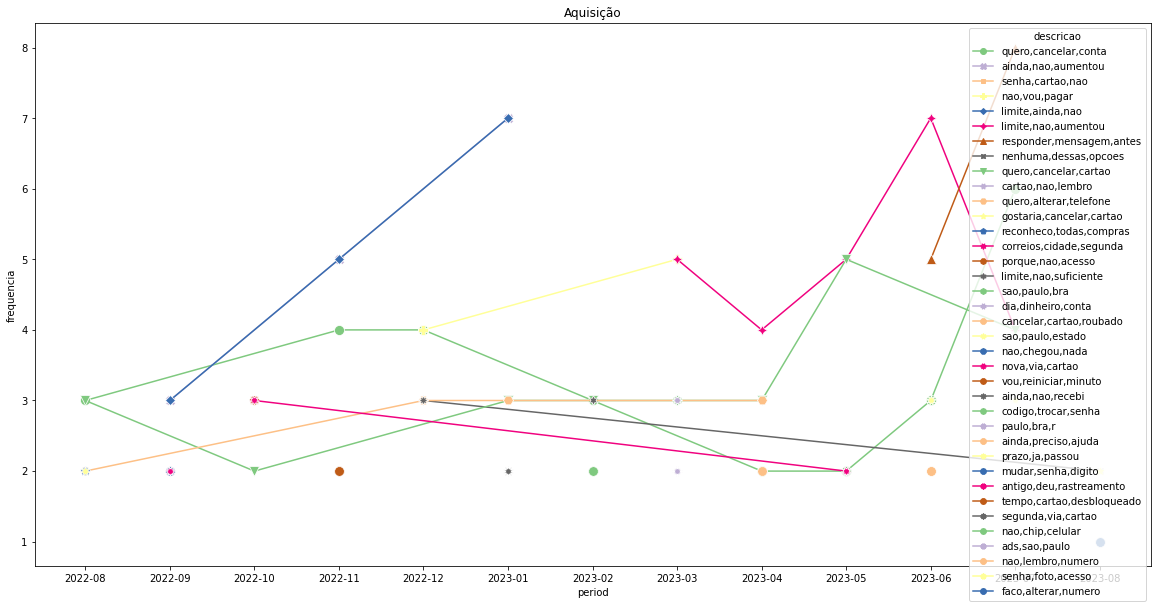

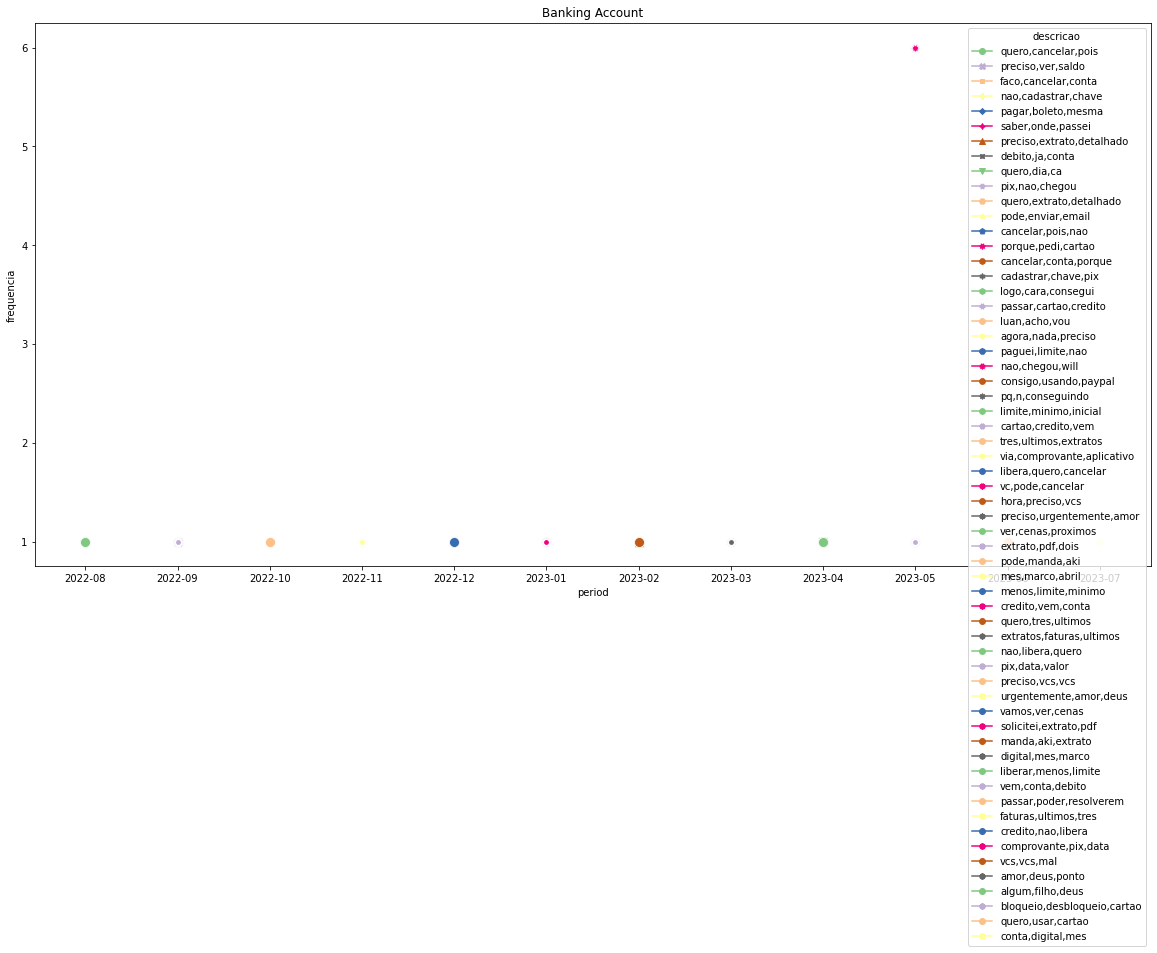

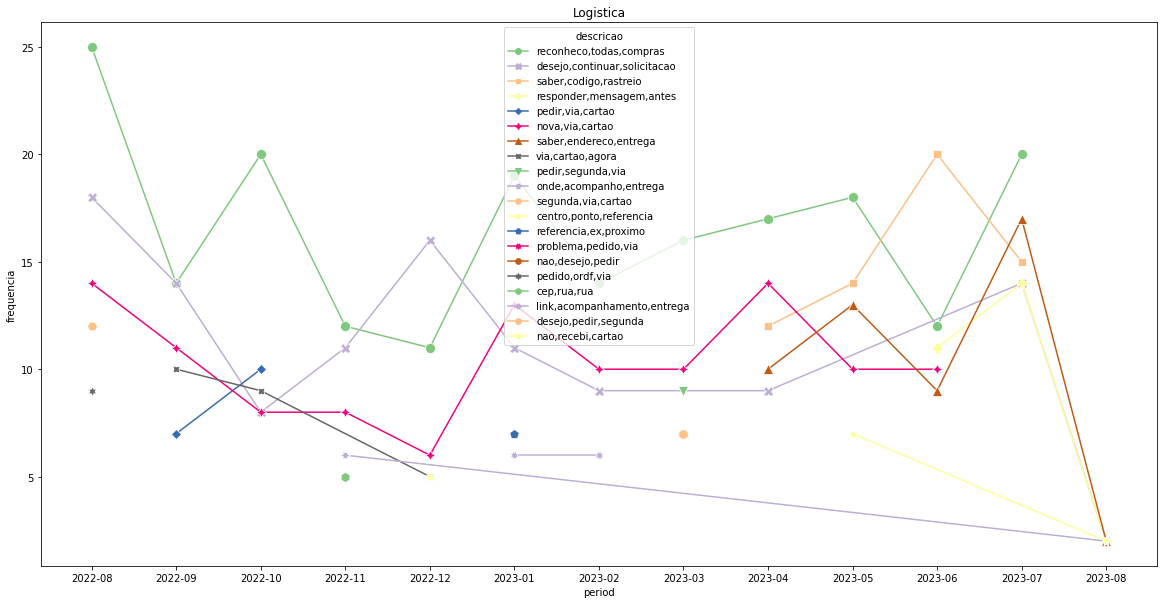

TypeError: expected string or bytes-like object

In [18]:
lista = []

hierarquia = 'hierarquia_analise'

for i in df_clean[hierarquia].unique():
    
    df_assunto = df_clean[df_clean[hierarquia] == i]

    try:
        df_agg_tmp = arabica_freq(
                text = df_assunto['ds_message_tratada'],
                time = df_assunto['dt_envio_mensagem'],
                time_freq = 'M',            
                max_words = 5,              
                stopwords = ['portuguese'], 
                skip = [stopwords],         
                numbers = True,             
                punct = True,               
                lower_case = True)

        #df_agg_tmp = df_agg_tmp.iloc[8:]
        df_agg_tmp['termo1'] = df_agg_tmp['trigram'].str.split(":").str[0]
        df_agg_tmp['termo2'] = df_agg_tmp['trigram'].str.split(":").str[1]
        df_agg_tmp['termo3'] = df_agg_tmp['trigram'].str.split(":").str[2]
        df_agg_tmp['termo4'] = df_agg_tmp['trigram'].str.split(":").str[3]
        df_agg_tmp['termo5'] = df_agg_tmp['trigram'].str.split(":").str[4]
        df_agg_tmp['freq_termo5'] = df_agg_tmp['trigram'].str.split(":").str[5]

        regex = r"(\d+),"

        df_agg_tmp['freq_termo1']  = df_agg_tmp['termo2'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
        df_agg_tmp['termo2']  = df_agg_tmp['termo2'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]

        df_agg_tmp['freq_termo2']  = df_agg_tmp['termo3'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
        df_agg_tmp['termo3']  = df_agg_tmp['termo3'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]

        df_agg_tmp['freq_termo3']  = df_agg_tmp['termo4'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
        df_agg_tmp['termo4']  = df_agg_tmp['termo4'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]

        df_agg_tmp['freq_termo4']  = df_agg_tmp['termo5'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[0]
        df_agg_tmp['termo5']  = df_agg_tmp['termo5'].apply(lambda x: re.sub(regex, r"\1-", x)).str.split("-").str[1]

        df_agg_tmp_m = df_agg_tmp.melt(id_vars=['period'], value_vars=['termo1','termo2','termo3','termo4','termo5']
                                                        , var_name='ranking', value_name='descricao').join(
                    df_agg_tmp.melt(id_vars=['period'], value_vars=['freq_termo1', 'freq_termo2', 'freq_termo3', 'freq_termo4', 'freq_termo5']
                                                        , var_name='freq', value_name='frequencia')[['frequencia']])
                                                        
        df_agg_tmp_m['period'] = df_agg_tmp_m['period'].astype('string')
        df_agg_tmp_m['frequencia'] = df_agg_tmp_m['frequencia'].astype('int')
        
        plt.figure(figsize = (20,10))
        sns.lineplot(data=df_agg_tmp_m, x='period', y='frequencia', hue='descricao', style='descricao', palette="Accent", markers=True, dashes=False, markersize=10).set(title=i)
        plt.savefig(f'{i}.png') #colocar /tmp/ no template final
        plt.show()
        
        
        #copiar codigo para exportação
        '''
        
        print("Saving Histogram image")
        ax = sns.barplot(x='frequência',y='palavras', data=top15, color = 'gold').set_title('Palavras mais frequentes no Bolso')
        ax.figure.set_size_inches(15, 12)
        sns.despine(left=True, bottom=True)
        plt.savefig(histogram_path)
        
        '''
        
        lista.append(i)
    
    except (IndexError, ValueError):
        pass